# Train, fit, and evaluate classifier <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


TODO:
- if/when datasets become large, consider implementing `dask_ml`

## Background



_Table 1: Some of the pros and cons of different classifiers available through scikit-learn_

<img align="center" src="classifier_pro_cons.PNG" width="700">

## Description

1. Split the training data into a training set and a test set
2. Optionally standardise the datasets
2. Train a classifier
3. Evaluate the classifier using a number of metrics
4. Optimise the model hyperparameters
5. Retrain the model using the optimised hyperparameters
6. Re-evaluate the classifier using a number of metrics
7. Optionally plot Receiver Operating Characteristic (ROC) Curves (for binary classification only)
6. Save model to disk

## Load packages

In [ ]:
# !pip install dask-ml
# !pip freeze | grep hdstats

In [1]:
# -- scikit-learn classifiers, uncomment the one of interest----

# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier

import os
import sys
import joblib
import numpy as np
import pandas as pd
from joblib import dump
import subprocess as sp
import dask.array as da
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

sys.path.append('../Scripts')
from deafrica_classificationtools import spatial_clusters, SKCV, spatial_train_test_split

%load_ext autoreload
%autoreload 2

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/env/lib/python3.6/site-packages/osgeo/gdal.py:107: DeprecationWarning: osr.py was placed in a namespace, it is now available as osgeo.osr
  DeprecationWarning)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Analysis Parameters

* `training_data`: Name and location of the training data `.txt` file output from runnning `1_Extract_training_data.ipynb`
* `Classifier`: This parameter refers to the scikit-learn classification model to use, first uncomment the classifier of interest in the `Load Packages` section and then enter the function name into this parameter `e.g. Classifier = SVC`   
* `class_dict`: A dictionary mapping the 'string' name of the classes to the integer values that represent our classes in the training data (e.g. `{'crop': 1., 'noncrop': 0.}`)
* `ncpus`: Set this value to > 1 to parallize the model fitting eg. npus=8. 
* `metrics` : A single string that denotes the scorer that would be used to find the best parameters for refitting the estimator to evaluate the predictions on the test set. See the scoring parameter page [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for a pre-defined list of options.
* `cv_splits` : Determines the number of k-fold cross-validations to conduct during testing of the model.  A higher number will reduce the possibility of over-fitting, but will require more time to compute. 5-10 is a good default number.
* `n_clusters` : Number of spatial clusters to apply to the cooridnate values on the training data samples.

In [2]:
training_data = "results/training_data/test_training_data.txt"
coordinate_data = "results/training_data/training_data_coordinates.txt"

Classifier = RandomForestClassifier

class_dict = {'crop':1, 'noncrop':0}

metric = 'balanced_accuracy' #good for binary classifications

cv_splits = 5

n_clusters = 100

test_size = 0.15

### Find the number of cpus

In [3]:
try:
    ncpus = int(float(sp.getoutput('env | grep CPU')[-4:]))
except:
    ncpus = int(float(sp.getoutput('env | grep CPU')[-3:]))

print('ncpus = '+str(ncpus))

ncpus = 2


## Import training  and coordinate data

In [4]:
# load the data
model_input = np.loadtxt(training_data)
coordinates = np.loadtxt(coordinate_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:]

# Extract relevant indices from training data
model_col_indices = [column_names.index(var_name) for var_name in column_names[1:]]

## Split into training and testing data

Here will split the training data into four seperate datasets:
* `train_features` : the feature layer data we will train the classifier on
* `test_features` :  the feature layer data we will use to test the accuracy/precision of our classifier
* `train_labels` : the dependent variables we will train the classifier on (in the default example the integers that represent the classes i.e. 1. and 0.)
* `test_labels` : the dependent variables we will use to test the accuracy/precision of our classifier.

Set the `test_size` to a fraction between 0 and 1, this will determine what fraction of the dataset will be set aside as the testing dataset. There is a trade-off here between having a larger test set that will help us better determine the quality of our classifier, and leaving enough data to train the classifier. A good deafult is to set 20 % of your dataset aside for testing purposes.

## Spatial train-test-split

To better handle spatial autocorrelations.


In [5]:
train_features, test_features, train_labels, test_labels = spatial_train_test_split(X = model_input[:, model_col_indices],
                                                             y = model_input[:, 0],
                                                             coordinates = coordinates,
                                                             n_groups=n_clusters,
                                                             cluster_method='GMM',
                                                             covariance_type= 'tied',
                                                             kfold_method = 'SpatialShuffleSplit',
                                                             test_size=test_size,
                                                             train_size=None,
                                                             balance=True,
                                                             random_state=0
                                                            )

print("train_features shape:", train_features.shape)
print("test_features shape:", test_features.shape)

train_features shape: (501, 15)
test_features shape: (165, 15)


## Optional: Feature scaling

Feature scaling (standardisaton or normalisation) of datasets is a common requirement for many machine learning estimators. For example, the objective function within the RBF kernel of Support Vector Machines assumes that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly.

Below, we demonstrate the use of a common preprocessing function provided by [sklearn](https://scikit-learn.org/stable/modules/preprocessing.html), `StandardScaler`, which will standardise the values in an array to the array's mean and standard deviation via the formuala: `z = (x-u/s)`, where `u` is the mean of and `s` is the standard deviation.

To centre all values around 0, set `with_mean = False` within the `StandardScalar()` method

> **Note**: <ins>Always</ins> split your data into a training and test set **BEFORE** feature scaling (normalisation or standardisation) is applied. This is because the test set is intended to be a completly independent set of data. If feature scaling is applied before splitting, then the data will share a common mean and standard deviation (i.e. **information leakage** occurs between the training and test datasets).

> **Note**: <ins>Do not</ins> apply standardisation to categorical data (dummy variables).

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Instatiate a standard scalar method
sc = StandardScaler()

#apply standard scalar params to the training set
train_features = sc.fit_transform(train_features)

#apply the same standard scalar params to the test set
test_features = sc.fit_transform(test_features)

# apply the same standard scalar params to all the feature data, this is for our hyperparameter
# searching later on which relies on the full dataset.
model_input[:, model_col_indices] = sc.fit_transform(model_input[:, model_col_indices])


Now, we need to export the standard scalar values for use in our classification in the subseqeuent script `Predict.ipnyb`, as these same values are applied to our prediction dataset.

In [ ]:
dump(sc, 'results/std_scaler.bin', compress=True)

## Train default classifier

The intial model will rely on the default parameters, during hyperparameter tuning later we will refine these parameters

In [6]:
model = Classifier(random_state=1, n_jobs=ncpus, verbose=0)
model.fit(train_features, train_labels)

RandomForestClassifier(n_jobs=2, random_state=1)

## Evaluating Classifier

The following cells will help you examine the classifier and improve the results.  We can do this by:
* Calculating the `cross-validation scores`, producing a `classification report` and a `confusion matrix`
* Finding out which feature layers (bands in the input data) are most useful for classifying, and which are not,
* Evaluating which model parameters (hyperparameters) optimize the model results 
* Plotting some of the decision trees from the random forest model to visualize how the algorithm is splitting the data


### Accuracy metrics

We can use the sample of test data we partitioned earlier to test the accuracy of the trained model on this new, "unseen" data.

We can also put our training data through a k-fold cross validation procedure as an additional way to test the model's accuracy and variance


## Spatial cross-validation

In [8]:
#predict on the test dataset
predictions = model.predict(test_features)

#generate n_splits of train-test_splits
ss = SKCV(X=model_input[:, model_col_indices],
             y=model_input[:, 0],
             coordinates=coordinates,
             n_groups=n_clusters,
             n_splits=cv_splits,
             cluster_method='GMM',
             covariance_type= 'tied',
             kfold_method='SpatialKFold',
             test_size=test_size,
             train_size=None,
             random_state=0,
             balance=True
            )

# cross validate accounting for spatial groups
score = cross_val_score(model,
                        model_input[:, model_col_indices],
                        model_input[:, 0],
                        cv=ss,
                        scoring=metric
                        )

In [9]:
print("=== Confusion Matrix ===")
print(confusion_matrix(test_labels, predictions))
print('\n')
print("=== Overall Accuracy ===")
accuracy = accuracy_score(test_labels, predictions)
print(round(accuracy, 3))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, predictions))
print('\n')
print("=== Spatial K-Fold Cross-Val "+metric+" Scores ===")
print(np.array_str(score, precision=2, suppress_small=True))
print("Mean: "+ str(round(score.mean(), 2)))
print("Std: "+ str(round(score.std(), 2)))

=== Confusion Matrix ===
[[ 37  10]
 [ 14 104]]


=== Overall Accuracy ===
0.855


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.73      0.79      0.76        47
         1.0       0.91      0.88      0.90       118

    accuracy                           0.85       165
   macro avg       0.82      0.83      0.83       165
weighted avg       0.86      0.85      0.86       165



=== Spatial K-Fold Cross-Val balanced_accuracy Scores ===
[0.73 0.89 0.71 0.77 0.81]
Mean: 0.78
Std: 0.06


### Determine Feature Importance

Extract classifier estimates of the relative importance of each band/variable for training the classifier. Useful for potentially selecting a subset of input bands/variables for model training/classification (i.e. optimising feature space). Results will be presented in descending order with the most important features listed first.  Importance is reported as a relative fraction between 0 and 1.

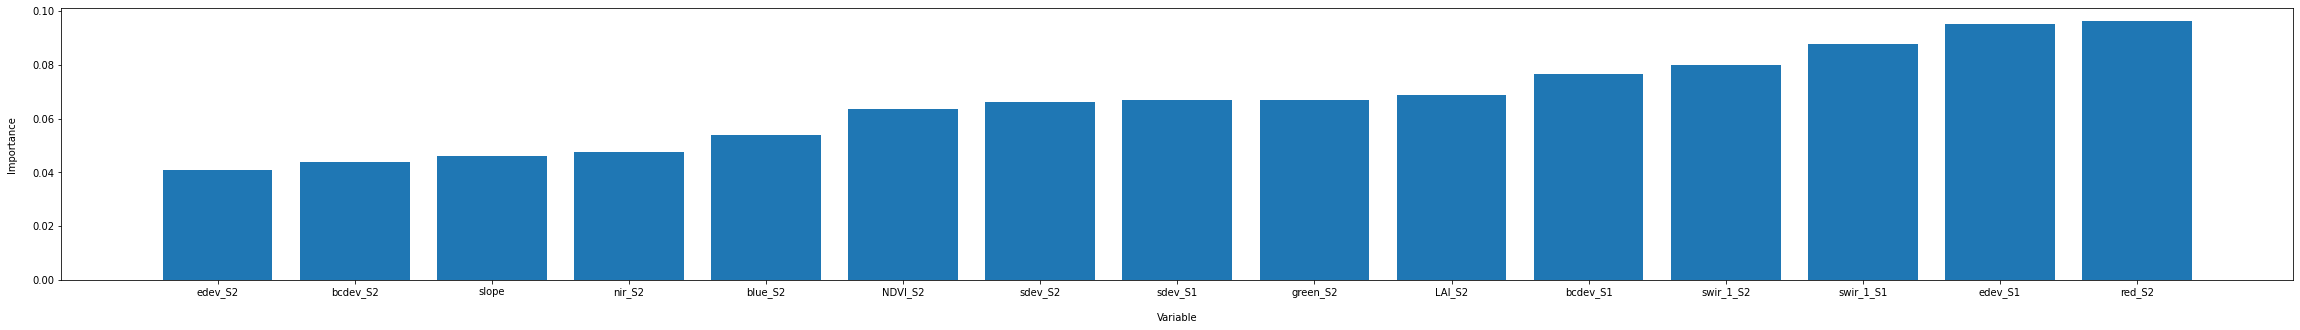

In [10]:
# This shows the feature importance of the input features for predicting the class labels provided
order = np.argsort(model.feature_importances_)

plt.figure(figsize=(40,5))
plt.bar(x=np.array(column_names[1:])[order],
        height=model.feature_importances_[order])
plt.gca().set_ylabel('Importance', labelpad=15)
plt.gca().set_xlabel('Variable', labelpad=15);

## Optimize hyperparameters

Hyperparameter searches are a required process in machine learning. Machine learning models require certain “hyperparameters”, model parameters that can be learned from the data. Finding these good values for these parameters is a “hyperparameter search” or an “hyperparameter optimization.”

To optimize the parameters in our model, we use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to exhaustively search through a set of parameters and determine the combination that will result in the highest accuracy based upon the accuracy metric defined.


### Grid Search with Cross Validation


> **Note**: the parameters in the `param_grid` object depend on the classifier being used. The default example is set up for a random forest classifier, to adjust ther paramaters to suit a different classifier, look up the important parameters under the relevant [sklearn documentation](https://scikit-learn.org/stable/supervised_learning.html). 

In [11]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'class_weight': ['balanced', None],
    'max_depth': [None,5,10,20],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2,3,4],
    'n_estimators': [200,300,400]
}

In [12]:
# generate n_splits of train-test_splits
ss = SKCV(X=model_input[:, model_col_indices],
          y=model_input[:, 0],
          coordinates=coordinates,
          n_groups=n_clusters,
          n_splits=cv_splits,
          cluster_method='GMM',
          covariance_type='tied',
          kfold_method='SpatialShuffleSplit',
          test_size=test_size,
          train_size=None,
          random_state=0,
          balance=10
          )

In [13]:
#instatiate a gridsearchCV
clf = GridSearchCV(model,
                   param_grid,
                   scoring=metric,
                   verbose=1,
                   cv=ss,
                   n_jobs=ncpus)

clf.fit(model_input[:, model_col_indices], model_input[:, 0])

print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   20.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  5.5min
[Parallel(n_jobs=2)]: Done 1080 out of 1080 | elapsed:  7.4min finished


The most accurate combination of tested parameters is: 
{'class_weight': 'balanced',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 400}


## Retrain model

Using the best parameters from our hyperparmeter optmization search, we now re-run our model and re-test its accuracy.

In [15]:
#create a new model
new_model = Classifier(**clf.best_params_, random_state=1, n_jobs=ncpus)
new_model.fit(train_features, train_labels)

#generate new predictions
predictions = new_model.predict(test_features)

#generate n_splits of train-test_splits
ss = SKCV(X=model_input[:, model_col_indices],
                 y=model_input[:, 0],
                 coordinates=coordinates,
                 n_groups=n_clusters,
                 n_splits=cv_splits,
                 cluster_method='GMM',
                 covariance_type= 'tied',
                 kfold_method='SpatialShuffleSplit',
                 test_size=test_size,
                 train_size=None,
                 random_state=0,
                 balance=10
                )

#generate metrics
new_score = cross_val_score(model,
                        model_input[:, model_col_indices],
                        model_input[:, 0],
                        cv=ss,
                        scoring=metric
                        )

In [16]:
print("=== Confusion Matrix ===")
print(confusion_matrix(test_labels, predictions))
print('\n')
print("=== Overall Accuracy ===")
new_accuracy = accuracy_score(test_labels, predictions)
print(round(new_accuracy, 2))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, predictions))
print('\n')
print("=== Spatial K-Fold Cross-Val "+metric+" Scores ===")
print(np.array_str(new_score, precision=2, suppress_small=True))
print("Mean: "+ str(round(new_score.mean(), 2)))
print("Std: "+ str(round(new_score.std(), 2)))

=== Confusion Matrix ===
[[ 35  12]
 [  9 109]]


=== Overall Accuracy ===
0.87


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.80      0.74      0.77        47
         1.0       0.90      0.92      0.91       118

    accuracy                           0.87       165
   macro avg       0.85      0.83      0.84       165
weighted avg       0.87      0.87      0.87       165



=== Spatial K-Fold Cross-Val balanced_accuracy Scores ===
[0.71 0.63 0.54 0.89 0.65]
Mean: 0.68
Std: 0.12


In [17]:
print("Improvement in K-Fold Cross-Val "+metric+" score:")
print(round(new_score.mean() - score.mean(),4))
print('\n')
print("Improvement in overall accuracy:")
print(round(new_accuracy - accuracy,4))

Improvement in K-Fold Cross-Val balanced_accuracy score:
-0.101


Improvement in overall accuracy:
0.0182


## Optional: Receiver Operating Characteristic (ROC) Curve

> **Note** :This is for binary classifications only

The final metric we use to evaluate our classifier is to plot the Receiver Operating Characteristic (ROC) curve. An ROC curve is an excellent method of measuring the performance of a classification model. The True Positive Rate (TPR) is plot against the False Positive Rate (FPR) for the probabilities of a classifier's predictions. The area under the plot is calculated.

**The higher the area under the curve (AUC), the better the model is at distinguishing the classes**.

The steps are as follows:

1. Calculate probabilities of the classification using `predict_proba`
2. Select a class you want to plot, in this case the second class (with label 1.0)
3. Using `sklearn.metrics.roc_curve`, calculate the TPR and the FPR.
4. Plot TPR on the y-axis and FPR on the x-axis.
5. Calculate the area under this curve using `sklearn.metrics.auc`

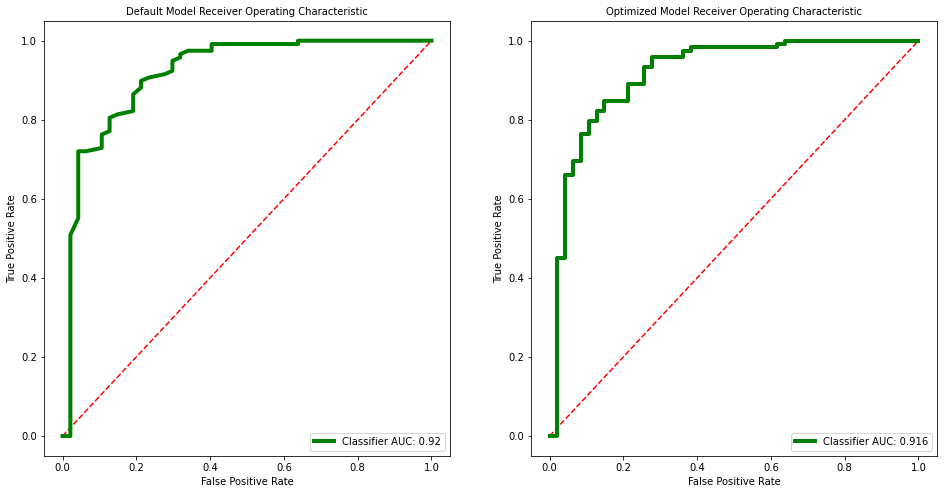

In [18]:
fig, axes = plt.subplots(1,2, figsize = (16, 8))

#Default model
axes[0].plot([0,1], [0,1], 'r--')
probs = model.predict_proba(test_features)
# Reading probability of second class
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(test_labels, probs)
roc_auc = auc(fpr, tpr)

label = 'Classifier AUC:' + ' {0:.2f}'.format(roc_auc)
axes[0].plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
axes[0].set_xlabel('False Positive Rate', fontsize = 10)
axes[0].set_ylabel('True Positive Rate', fontsize = 10)
axes[0].set_title('Default Model Receiver Operating Characteristic', fontsize = 10)
axes[0].legend(loc = 'lower right', fontsize = 10)

#Optimized model
axes[1].plot([0,1], [0,1], 'r--')
probs = new_model.predict_proba(test_features)
# Reading probability of second class
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(test_labels, probs)
roc_auc = auc(fpr, tpr)

label = 'Classifier AUC:' + ' {0:.3f}'.format(roc_auc)
axes[1].plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
axes[1].set_xlabel('False Positive Rate', fontsize = 10)
axes[1].set_ylabel('True Positive Rate', fontsize = 10)
axes[1].set_title('Optimized Model Receiver Operating Characteristic', fontsize = 10)
axes[1].legend(loc = 'lower right', fontsize = 10);

## Save the model

Running this cell will export the classifier as a binary`.joblib` file. This will allow for importing the model in the subsequent script, `4_Predict.ipynb` 


In [ ]:
dump(new_model, 'results/ml_model.joblib')

## Recommended next steps

To continue working through the notebooks in this `Scalable Machine Learning on the ODC` workflow, go to the next notebook `4_Predict.ipynb`.

1. [Extracting_training_data](1_Extracting_training_data.ipynb) 
2. [Inspect_training_data](2_Inspect_training_data.ipynb)
3. **Train_fit_evaluate_classifier**
4. [Predict](4_Predict.ipynb)
5. [Accuracy_assessment](5_Accuracy_assessment.ipynb)
6. [Object-based_filtering](6_Object-based_filtering_(optional).ipynb)


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** August 2020


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)